In [1]:
%matplotlib inline
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import mio
import os, glob, random

In [2]:
def is_valid(GeoSeries):
    for geom in GeoSeries:
        assert geom.is_valid
        if geom.type not in ['Polygon','MultiPolygon']:
            print('geometry is', geom.type, "expected Polygon")
            assert False

In [3]:
def cutpoint(p1:tuple, p2:tuple)->tuple:
    "calc point cuts zero plane"
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if (z2 - z1) != 0:
        k = - z1 / (z2 - z1)
    else:
        k = 0
    x0 = x1 + k * (x2 - x1)
    y0 = y1 + k * (y2 - y1)
    z0 = z1 + k * (z2 - z1)
    return x0, y0, z0

In [4]:
def slice_line(p1:tuple, p2:tuple)->list:
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    if z1>0 and z2>0:
        # line above zero plane
        return [(x1, y1, 0), (x2, y2, 0)]
    if z1<0 and z2<0:
        # Line below zero plane
        return []
    p0 = cutpoint(p1, p2)
    if z1<=0:
        # replace first point
        return [p0, p2]
    if z2<=0:
        # replace second point
        return [p1, p0]

In [5]:
def slice_tri(poly:Polygon, h:float, tri_buffer:float):
    " Slice one triangle"
    p1 =   poly.exterior.coords[0]
    p2 =   poly.exterior.coords[1]
    p3 =   poly.exterior.coords[2]
    p1 = [p1[0], p1[1], p1[2]-h]
    p2 = [p2[0], p2[1], p2[2]-h]
    p3 = [p3[0], p3[1], p3[2]-h]
    l = []
    l1 = slice_line(p1, p2)
    l2 = slice_line(p2, p3)
    l3 = slice_line(p3, p1)
    l = l1 + l2 + l3
    # aribitrary buffer to avoid topology errors (1 cm!)
    poly = Polygon(l).buffer(tri_buffer)
    if poly.area == 0:
        return
    
    return poly

In [6]:
def make_level(tri, h, tri_buffer):
    pl = []
    for t in tri:
        poly = Polygon(t)
        poly = slice_tri(poly, h, tri_buffer)
        if poly is not None:   # avoid empty polygons
            pl.append(poly)
    gdf = gpd.GeoDataFrame(geometry=pl)
    
    # try to fix topolgy array
    gdf.geometry = gdf.geometry.buffer(0)
    
    #is_valid(gdf.geometry)
    gdf['id'] = 1
    gdf = gdf.dissolve('id')
    return gdf.geometry[1]

In [7]:
def read_obj_file(model_path:str)->tuple:
    # read obj file
    fin = open(model_path)
    v_list = []
    f_list = []
    for s in fin:
        l = s.split()
        if l[0] == 'g':
            lon = float(l[1])
            lat = float(l[2])
        if l[0] == 'v':
            vertex = float(l[1]), float(l[2]),float(l[3])
            v_list.append(vertex)                                    
        if l[0] == 'f':
            poi = l[1:]
            poi = [int(x)-1 for x in poi]
            f_list.append(poi)
    return v_list, f_list, lon, lat

In [8]:
def resolve_tris(v_list:list, f_list:list)->list:
    tris = []
    for f in f_list:
        tri = [v_list[p] for p in f]
        tris.append(tri)
    return tris

In [9]:
def get_hight_range(tris:list)->tuple:
    h_min = 8848
    h_max = 0
    for tri in tris:
        for point in tri:
            h = point[2]
            if h > h_max: h_max = h
            if h < h_min: h_min = h
    return h_min, h_max

In [10]:
def levels_df(tris:list, tri_buffer:float, min_dif:float) -> gpd.GeoDataFrame:
    h_min, h_max = get_hight_range(tris)
    h_min = int(h_min-1)
    h_max = int(h_max+1)
    gl = []
    area = 0
    for h in range(h_min, h_max):
        row = {}
        row['h'] = h
        geom =  make_level(tris, h, tri_buffer)
        ar = geom.area
        row['geometry'] = geom
        if abs(ar - area) > min_dif and ar>min_dif:
            gl.append(row)
            area = ar
    gdf = gpd.GeoDataFrame(gl)
    gdf = gdf.iloc[::-1]
    gdf = gdf.reset_index(drop=True)
    return gdf.copy()

In [11]:
def make_v_f(row:gpd.GeoSeries)->list:
    v_list = []
    f_list = []
    i = 0
    for coord in row.geometry.exterior.coords:
        i += 1
        xyz = (coord[0], coord[1], row.h)
        v_list.append(xyz)
        f_list.append(i)
    return v_list, f_list

In [12]:
def write_level_obj(gdf:gpd.GeoDataFrame, obj_dest:str):
    fout = open(obj_dest, 'w')
    fout.write('g\n')
    i_offset = 0
    for ind, row in gdf[:].iterrows():
        v_list, f_list = make_v_f(row)
        for coord in v_list:
            s = "v %f %f %f\n" % coord
            fout.write(s)
        sv = 'f '
        for i in f_list:
            sv = sv + " " + str(i + i_offset)
        fout.write(sv + "\n")
        i_offset += len(f_list)
    fout.close()

In [13]:
def cut_out(gdf:gpd.GeoDataFrame, cut_buffer:float):
    gdf = gdf.copy()
    gdf.geometry = gdf.geometry.buffer(0)
    gdf.geometry = [geom for geom in gdf.geometry if geom.area>1]
    for i in range(len(gdf)-1):
        upper = gdf.geometry.iloc[0:i+1]
        #is_valid(upper)
        
        lower = gdf.geometry.iloc[i+1:]
        #is_valid(lower)
        
        geom = upper.unary_union.buffer(cut_buffer)
        #assert geom.is_valid
        
        # try to decrease topologyerrors by buffering
        lower_cut = lower.buffer(0).difference(geom)

        
        lower_cut = lower_cut.buffer(0)
        #is_valid(lower_cut)
               
        res = upper.append(lower_cut)
        gdf.geometry = res
        gdf.geometry.buffer(0)
    return gdf

In [14]:
def obj_to_json(model_path:str)->gpd.GeoDataFrame:
    v_list, f_list, lon, lat = read_obj_file(model_path)
    tris = resolve_tris(v_list, f_list)
    gdf = levels_df(tris, tri_buffer=0.001, min_dif=1)
    gdf = cut_out(gdf, cut_buffer=0.001)
    gdf = mio.disagg(gdf)
    gdf.geometry = gdf.geometry.buffer(0)
    gdf['lon'] = lon
    gdf['lat'] = lat
    gdf['model_path'] = model_path
    dest = os.path.splitext(model_path)[0] + '.json'
    gdf.to_file(dest, driver="GeoJSON")
    return gdf

In [ ]:
%%time
fl = glob.glob('obj/*.obj')
print('files', len(fl))
for i, obj_file in enumerate(fl):
    mio.show_perc(i, len(fl), 5)
    gdf = obj_to_json(obj_file)

files 1752
0.0% 

C:\tools\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


0.29% 0.57% 0.86% 1.14% 1.43% 1.71% 2.0% 2.28% 2.57% 2.85% 3.14% 3.42% 3.71% 4.0% 4.28% 4.57% 4.85% 5.14% 5.42% 5.71% 5.99% 6.28% 6.56% 6.85% 7.13% 7.42% 7.71% 7.99% 8.28% 8.56% 8.85% 9.13% 9.42% 9.7% 9.99% 10.27% 10.56% 10.84% 11.13% 11.42% 11.7% 11.99% 12.27% 12.56% 12.84% 13.13% 13.41% 13.7% 13.98% 14.27% 14.55% 14.84% 15.13% 15.41% 15.7% 15.98% 16.27% 16.55% 16.84% 17.12% 17.41% 17.69% 17.98% 18.26% 18.55% 18.84% 19.12% 19.41% 19.69% 19.98% 20.26% 20.55% 20.83% 21.12% 21.4% 21.69% 21.97% 22.26% 22.55% 22.83% 23.12% 23.4% 23.69% 23.97% 24.26% 24.54% 24.83% 25.11% 25.4% 25.68% 25.97% 26.26% 26.54% 26.83% 27.11% 27.4% 27.68% 27.97% 28.25% 28.54% 28.82% 29.11% 29.39% 29.68% 29.97% 30.25% 30.54% 30.82% 31.11% 31.39% 31.68% 31.96% 32.25% 32.53% 32.82% 33.11% 33.39% 33.68% 33.96% 34.25% 34.53% 34.82% 35.1% 35.39% 35.67% 35.96% 36.24% 36.53% 36.82% 37.1% 37.39% 37.67% 37.96% 38.24% 38.53% 38.81% 39.1% 39.38% 39.67% 39.95% 40.24% 40.53% 40.81% 41.1% 41.38% 41.67% 41.95% 42.24% 42.52% 42.81%

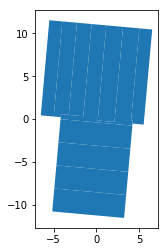

In [18]:
obj = random.choice(fl)
test = os.path.splitext(obj)[0] + ".json"
gdf = gpd.read_file(test, driver="GeoJSON")
gdf.plot()

In [20]:
mio.write_tab(gdf, 'levels.tab')

3 rows of type MultiPolygon written to mapinfo file.
